# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from pytorch_model import FCNet, Flattener
from pytorch_trainer import Trainer
from pytorch_dataloader import NumberDataLoader

from torchvision import transforms
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
device

device(type='cuda', index=0)

# Загружаем данные

In [4]:
# First, lets load the dataset
loader = NumberDataLoader()
train_loader, val_loader = loader.get_data_loaders(batch_size=64, num_workers=0)

In [5]:
def accuracy(predictions, labels):
    indices = torch.argmax(predictions, dim=1)
    correct_samples = torch.sum(indices == labels)
    total_samples = len(labels)
    
    return float(correct_samples) / total_samples

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          ).type(torch.cuda.FloatTensor)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

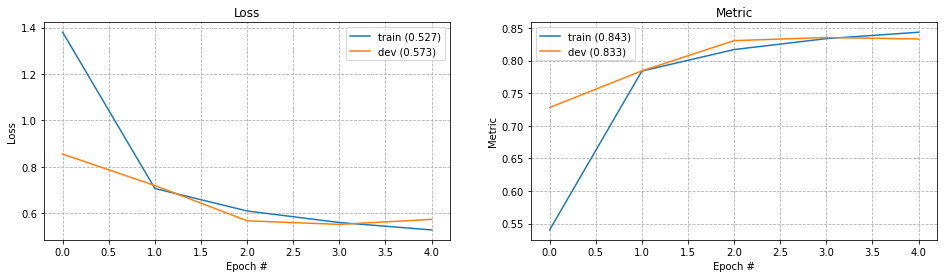

0.8329806839123609

In [19]:
trainer = Trainer(nn_model, train_loader, val_loader)
loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [20]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

loader = NumberDataLoader(tfs=tfs)
train_loader, val_loader = loader.get_data_loaders(batch_size=64, num_workers=0)                                        

C:\Users\User\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1207: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

(32, 32)


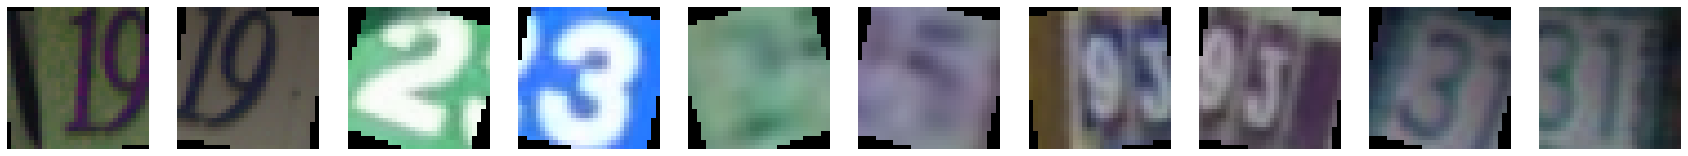

In [19]:
# transforms.GaussianBlur(7)

tfs = transforms.Compose([
    # transforms.GaussianBlur(7),
    transforms.ColorJitter(hue=.20, saturation=.50),
    # transforms.CenterCrop(25),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomPerspective(),
    # transforms.RandomAffine(5, interpolation=PIL.Image.BILINEAR),
    transforms.RandomRotation(20, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        print(x.size)
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [20]:
# TODO: 
tfs = transforms.Compose([
    # transforms.GaussianBlur(7),
    # transforms.RandomPerspective(),
    transforms.ColorJitter(hue=.20, saturation=.50),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

loader = NumberDataLoader(tfs=tfs)
train_loader, val_loader = loader.get_data_loaders(batch_size=64, num_workers=0)  


C:\Users\User\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


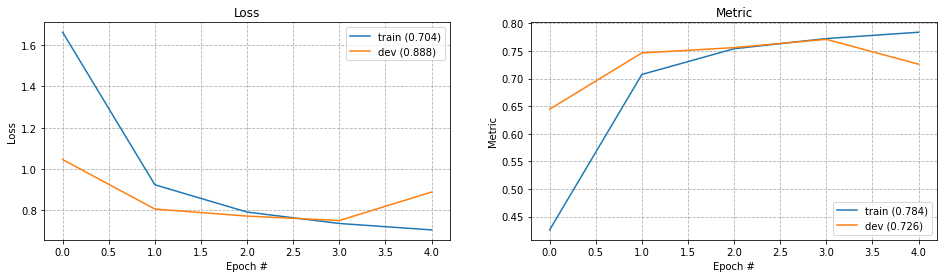

0.7258890178144837

In [21]:
trainer = Trainer(nn_model, train_loader, val_loader)
loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

print(device)
trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=5)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [6]:
# TODO: Implement LeNet-like architecture for SVHN task
nn_model = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
                nn.BatchNorm2d(6),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True),
                Flattener(),
                nn.Linear(in_features=16*5*5, out_features=120),
                nn.BatchNorm1d(120),
                nn.ReLU(inplace=True),
                nn.Linear(in_features=120, out_features=84),
                nn.BatchNorm1d(84),
                nn.ReLU(inplace=True),
                nn.Linear(in_features=84, out_features=10),
          ).type(torch.cuda.FloatTensor)

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.50),
    transforms.RandomRotation(25, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

C:\Users\User\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1207: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


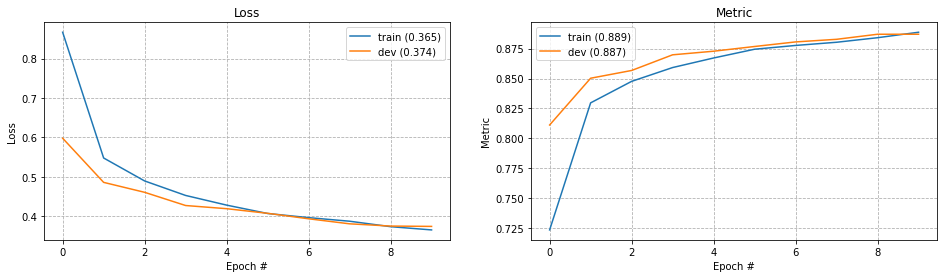

0.8870384274110982

In [7]:
# Let's train it!

loader = NumberDataLoader(tfs=tfs)
train_aug_loader, val_loader = loader.get_data_loaders(batch_size=64, num_workers=0) 
trainer = Trainer(nn_model, train_aug_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=10)

# Подбор гиперпараметров

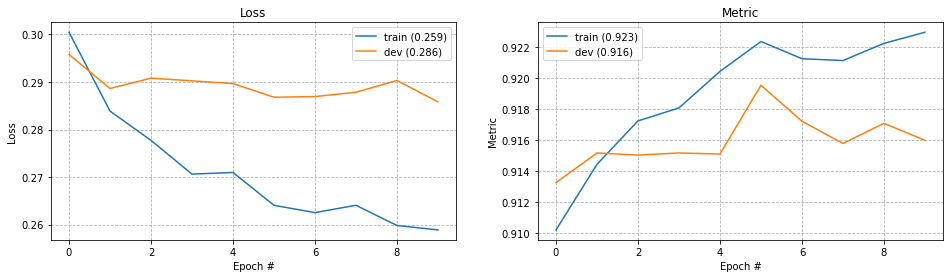

In [8]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'final_val_accuracy', 'step_size', 'batch_size'])

batch_size = 1000
loader = NumberDataLoader(tfs=tfs)
loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
train_aug_loader, val_loader = loader.get_data_loaders(batch_size=batch_size, num_workers=0) 
trainer = Trainer(nn_model, train_aug_loader, val_loader)


learning_rates = [2.5e-4]
reg = [3e-4]

epoch_num = 10
step_size = 4
run_record = {} 


for step, lr in enumerate(learning_rates):
    print("current step: ", step, "with lr: ", lr)
    for wd in reg:
        opt = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=0.5)
        last_validation_value = trainer.train(  opt=opt, 
                                                loss_fn=loss_fn, 
                                                metric_fn=accuracy, 
                                                device=device, 
                                                epochs=epoch_num,
                                                scheduler=scheduler)
        run_record[Hyperparams(lr, wd)] = RunResult(nn_model, last_validation_value, step_size, batch_size)


In [9]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best size: %s, best batch: %s" % (best_val_accuracy, best_run.step_size, best_run.batch_size))
        

Best validation accuracy: 0.92, best size: 4, best batch: 1000


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

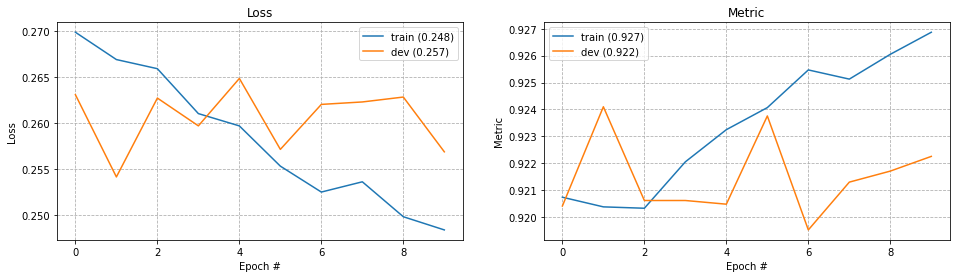

In [10]:
batch_range = [600]
steps = [4]

epoch_num = 10
loader = NumberDataLoader(tfs=tfs)
loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)


for bs in batch_range:
    train_aug_loader, val_loader = loader.get_data_loaders(batch_size=bs, num_workers=0) 
    trainer = Trainer(nn_model, train_aug_loader, val_loader)
    for step in steps:
        opt = optim.Adam(nn_model.parameters(), lr=2.5e-4, weight_decay=3e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step, gamma=0.5)
        last_validation_value = trainer.train(  opt=opt, 
                                                loss_fn=loss_fn, 
                                                metric_fn=accuracy, 
                                                device=device, 
                                                epochs=epoch_num,
                                                scheduler=scheduler)
        run_record[Hyperparams(lr, wd)] = RunResult(nn_model, last_validation_value, step, bs)

In [11]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best size: %s, best batch: %s" % (best_val_accuracy, best_run.step_size, best_run.batch_size))

Best validation accuracy: 0.92, best size: 4, best batch: 600


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [12]:
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=64)
final_test_accuracy = trainer.test(test_loader, device, accuracy)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.911339889366933


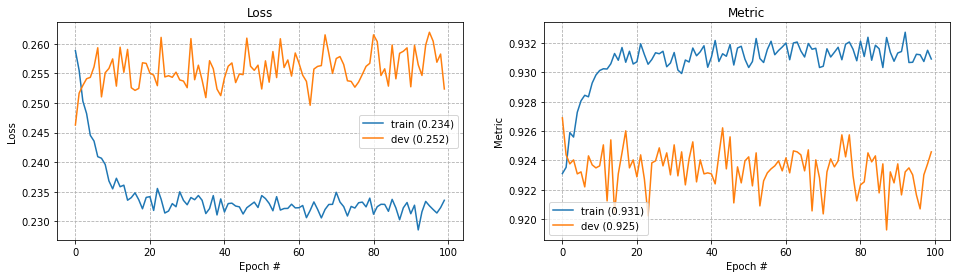

In [13]:
train_aug_loader, val_loader = loader.get_data_loaders(batch_size=600, num_workers=0) 
trainer = Trainer(nn_model, train_aug_loader, val_loader)

epoch_num = 100
opt = optim.Adam(nn_model.parameters(), lr=2.5e-4, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.5)
last_validation_value = trainer.train(  opt=opt, 
                                                loss_fn=loss_fn, 
                                                metric_fn=accuracy, 
                                                device=device, 
                                                epochs=epoch_num,
                                                scheduler=scheduler)


In [14]:
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=64)
final_test_accuracy = trainer.test(test_loader, device, accuracy)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9124923171481254


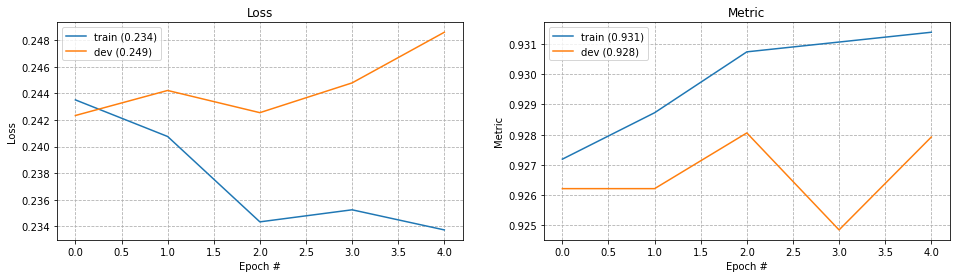

In [16]:
train_aug_loader, val_loader = loader.get_data_loaders(batch_size=800, num_workers=0) 
trainer = Trainer(nn_model, train_aug_loader, val_loader)

epoch_num = 5
opt = optim.Adam(nn_model.parameters(), lr=2.5e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.5)
last_validation_value = trainer.train(  opt=opt, 
                                                loss_fn=loss_fn, 
                                                metric_fn=accuracy, 
                                                device=device, 
                                                epochs=epoch_num,
                                                scheduler=scheduler)

In [17]:
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=64)
final_test_accuracy = trainer.test(test_loader, device, accuracy)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9134526736324524
